# Data processing

## Load data

In [163]:
from utils import *

import matplotlib.pyplot as plt
import seaborn as sb
from copy import deepcopy

%matplotlib inline

account_df = read_to_df("account.csv")
card_test_df = read_to_df("card_test.csv")
card_train_df = read_to_df("card_train.csv")
client_df = read_to_df("client.csv")
disp_df = read_to_df("disp.csv")
district_df = read_to_df("district.csv")
loan_test_df = read_to_df("loan_test.csv")
loan_train_df = read_to_df("loan_train.csv")
trans_test_df = read_to_df("trans_test.csv")
trans_train_df = read_to_df("trans_train.csv")

C:\Users\skelo\AppData\Local\Temp/ipykernel_18616/160468940.py:18: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  trans_train_df = read_to_df("trans_train.csv")


## Process data

### Process loan data + flip status to predict negatives instead of positives

In [164]:
#loan_train_df['status_rejected'] = loan_train_df['status'].apply(lambda x: -x)
#loan_test_df['status_rejected'] = loan_test_df['status'].apply(lambda x: -x)

#loan_train_df

### Process account data

In [165]:
avg_transactions_per_week = 3
avg_weeks_per_month = (365.25 / 7 / 12)

account_df['frequency'] = account_df['frequency'].apply(lambda x: 1 if x == 'monthly issuance' else avg_weeks_per_month if x == 'weekly issuance' else (365.25 / 7 / 12) * avg_transactions_per_week)
account_df.head()

,account_id,district_id,frequency,date
0,576,55,1.0,930101
1,3818,74,1.0,930101
2,704,55,1.0,930101
3,2378,16,1.0,930101
4,2632,24,1.0,930102


### Process client data

In [166]:
client_df["sex"] = client_df["birth_number"].apply(lambda x: 0 if int(str(x)[2:4]) > 50 else 1)
client_df["age"] = client_df["birth_number"].apply(lambda x: calculate_age(read_date(x)))

client_df.drop("birth_number", inplace=True, axis=1)

client_district_df = client_df.join(district_df)
client_district_df.head()

,client_id,district_id,sex,age,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,18,0,28,1.0,Hl.m. Praha,Prague,1204953.0,0.0,0.0,0.0,1.0,1.0,100.0,12541.0,0.29,0.43,167.0,85677,99107.0
1,2,1,1,53,2.0,Benesov,central Bohemia,88884.0,80.0,26.0,6.0,2.0,5.0,46.7,8507.0,1.67,1.85,132.0,2159,2674.0
2,3,1,0,58,3.0,Beroun,central Bohemia,75232.0,55.0,26.0,4.0,1.0,5.0,41.7,8980.0,1.95,2.21,111.0,2824,2813.0
3,4,5,1,42,4.0,Kladno,central Bohemia,149893.0,63.0,29.0,6.0,2.0,6.0,67.4,9753.0,4.64,5.05,109.0,5244,5892.0
4,5,5,0,38,5.0,Kolin,central Bohemia,95616.0,65.0,30.0,4.0,1.0,6.0,51.4,9307.0,3.85,4.43,118.0,2616,3040.0


### Process disposition data

In [167]:
disp_df["type"].replace({"OWNER": 1, "DISPONENT": 2}, inplace=True)
disp_df.head()

,disp_id,client_id,account_id,type
0,1,1,1,1
1,2,2,2,1
2,3,3,2,2
3,4,4,3,1
4,5,5,3,2


### Process transaction data

In [168]:
dataframes = [trans_train_df, trans_test_df]

for i in range(len(dataframes)):
    dataframes[i]["operation"].replace(
        {
            "credit in cash": 1,
            "collection from another bank": 2,
            "withdrawal in cash": 3,
            "remittance to another bank": 4,
            "credit card withdrawal": 5,
            "interest credited": 6
        },
        inplace=True
    )

    # Convert "withdrawal in cash" to "withdrawal" in type column
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal in cash", "type"] = "withdrawal"

    # Withdrawal amounts should be negative
    dataframes[i].loc[dataframes[i]["type"] == "withdrawal", "amount"] *= -1

    dataframes[i].drop(["k_symbol", "bank", "account"], axis=1, inplace=True)

trans_train_df, trans_test_df = dataframes

trans_train_df.head()

,trans_id,account_id,date,type,operation,amount,balance


### Process card data

In [169]:
dataframes = [card_train_df, card_test_df]

for i in range(len(dataframes)):
    dataframes[i]["type"].replace({"classic": 1, "junior": 2, "gold": 3}, inplace=True)

card_train_df, card_test_df = dataframes

card_train_df.head()

,card_id,disp_id,type,issued
0,1005,9285,1,931107
1,104,588,1,940119
2,747,4915,1,940205
3,70,439,1,940208
4,577,3687,1,940215


### Process loan data

In [170]:
dataframes = [loan_train_df, loan_test_df]

for i in range(len(dataframes)):
    # Merge loan dataframe with disposition dataframe
    dataframes[i] = dataframes[i].merge(right=disp_df, on="account_id", how="left")

    # Merge loan dataframe with card dataframe
    dataframes[i] = dataframes[i].merge(right=card_train_df, on="disp_id", how="left", suffixes=["_disp", "_card"])

    # Merge loan dataframe with account dataframe
    dataframes[i] = dataframes[i].merge(right=account_df, on="account_id", how="left")

loan_train_df, loan_test_df = dataframes

loan_train_df.head()

,loan_id,account_id,date_x,amount,duration,payments,status,disp_id,client_id,type_disp,card_id,type_card,issued,district_id,frequency,date_y
0,5314,1787,930705,96396,12,8033,-1,2166,2166,1,NaN,NaN,NaN,30,4.348214,930322
1,5316,1801,930711,165960,36,4610,1,2181,2181,1,NaN,NaN,NaN,46,1.000000,930213
2,6863,9188,930728,127080,60,2118,1,11006,11314,1,NaN,NaN,NaN,45,1.000000,930208
3,5325,1843,930803,105804,36,2939,1,2235,2235,1,NaN,NaN,NaN,12,1.000000,930130
4,7240,11013,930906,274740,60,4579,1,13231,13539,1,NaN,NaN,NaN,1,4.348214,930214


In [171]:
#pairplot_loan_df = loan_df.drop(labels=["loan_id", "card_id", "disp_id", "client_id", "account_id", "amount"], axis=1)
#sb.pairplot(pairplot_loan_df, hue='num_clients')

In [172]:
#corr_matrix = pairplot_loan_df.corr(method='spearman')
#plt.figure(figsize=(15,15))
#plt.title('Correlation Heatmap of client Dataset')
#a = sb.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
#a.set_xticklabels(a.get_xticklabels(), rotation=30)
#a.set_yticklabels(a.get_yticklabels(), rotation=30)
#plt.show()

# Classifiers

Columns to drop and feature target:

In [173]:
columns_to_drop = ["loan_id", "account_id", "disp_id", "client_id", "card_id", "district_id", "status", "type_card", "issued", "type_disp"]
target_column = "status"

loan_train_df.drop(columns_to_drop, axis=1).head()

,date_x,amount,duration,payments,frequency,date_y
0,930705,96396,12,8033,4.348214,930322
1,930711,165960,36,4610,1.000000,930213
2,930728,127080,60,2118,1.000000,930208
3,930803,105804,36,2939,1.000000,930130
4,930906,274740,60,4579,4.348214,930214


## Tune Models

### Decision Tree

In [174]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(1, 7)
}

# No feature selection
dt = tune_model(
    loan_train_df, 
    DecisionTreeClassifier(),
    parameter_grid, 
    columns_to_drop, 
    target_column
)

plot_tree(dt.best_estimator_);

NameError: name 'columns_to_drop' is not defined

### SVM
Needs to be scaled (StandardScaler)

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

parameter_grid = {
    'C': [1, 10, 50],
    'gamma': [0.001, 0.0001],
    # 'kernel': ['linear', 'poly', 'rbf']
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# No feature selection
svc = tune_model(
    loan_train_df, 
    SVC(probability=True), 
    parameter_grid,
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

svc.best_estimator_

Best score: 0.9394668489405331
Best parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


SVC(C=1, gamma=0.001, kernel='linear', probability=True)

###  K-nearest neighbours (KNN)
Just like the SVM model, the KNN model also requires the data to be scaled.

In [ ]:
from sklearn import neighbors

parameter_grid = {
    'n_neighbors': [4, 5, 6, 7, 10, 15],
    'leaf_size': [5, 10, 15, 20, 50, 100],
    'n_jobs': [-1],
    'algorithm': ['auto']
}

# No feature selection
knn = neighbors.KNeighborsClassifier()
knn = tune_model(
    loan_train_df, 
    neighbors.KNeighborsClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.9394668489405331
Best parameters: {'algorithm': 'auto', 'leaf_size': 5, 'n_jobs': -1, 'n_neighbors': 15}


### Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

parameter_grid = {}

# No feature selection
nb = tune_model(
    loan_train_df, 
    GaussianNB(),
    parameter_grid, 
    columns_to_drop, 
    target_column, 
    scaler=StandardScaler()
)

Best score: 0.9153252382817602
Best parameters: {}


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameter_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'n_jobs': [-1],  # Use all cores
    'criterion': ['gini', 'entropy']
}

# No feature selection
rfc = tune_model(
    loan_train_df, 
    RandomForestClassifier(), 
    parameter_grid, 
    columns_to_drop, 
    target_column
)

Best score: 0.9404047998784841
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100, 'n_jobs': -1}


## Comparing Models

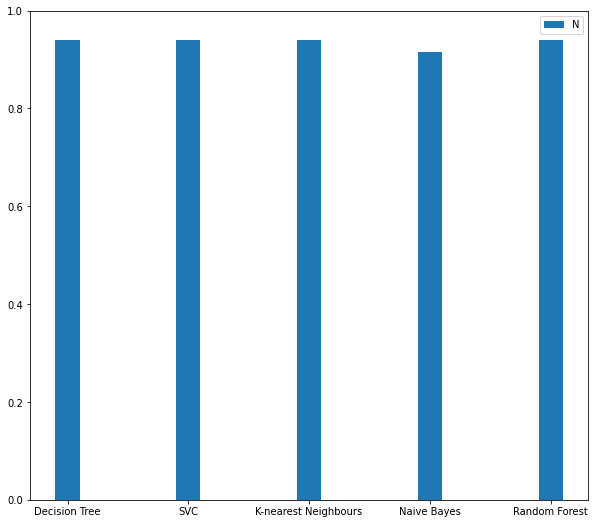

In [ ]:
import numpy as np

scores = {
    "Decision Tree" : [dt], #[dt_original, dt, dt_os_fs],
    "SVC" : [svc], #[svc_original, svc, svc_os_fs],
    "K-nearest Neighbours" : [knn], #[knn_original, knn, knn_os_fs],
    "Naive Bayes" : [nb], #[nb_original, nb, nb_os_fs],
    "Random Forest" : [rfc], #[rfc_original, rfc, rfc_os_fs]
}

labels ="No Feature selection" # ["No oversampling/No feature selection","No oversampling/Feature selection", "Oversampling/Feature selection"]

ind = np.arange(5)

plt.figure(figsize=(10,9))
plt.bar(ind, [i[0].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.2, [i[1].best_score_ for i in scores.values()], 0.2)
# ax = plt.bar(ind + 0.4, [i[2].best_score_ for i in scores.values()], 0.2)
plt.xticks(ind, scores.keys())
plt.legend(labels, loc=1)
plt.ylim(0, 1)
plt.show()

## Save results

In [ ]:
X_result = loan_test_df.drop(columns_to_drop, axis=1)

y_result = rfc.predict_proba(X_result)[:, 0]

result = pd.DataFrame({"Id": loan_test_df["loan_id"], "Predicted": y_result})
result.drop_duplicates(inplace=True)
result.to_csv("../out/result.csv", index=False)